In [3]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)

In [4]:
# Load the dataset
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECT 1/styles.csv', on_bad_lines='skip')  # 'on_bad_lines' handles any broken lines in the file

# Display the first few rows
df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
# Step 1: Check the shape
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Step 2: Check missing values
df.isnull().sum()

# Step 3: Quickly view datatypes
df.dtypes


Dataset has 44424 rows and 10 columns.


,0
id,int64
gender,object
masterCategory,object
subCategory,object
articleType,object
baseColour,object
season,object
year,float64
usage,object
productDisplayName,object


In [6]:
# Step 1: Drop rows where important fields are missing
important_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']
df = df.dropna(subset=important_columns)

# Step 2: Convert 'year' to integer (if not already)
df['year'] = df['year'].fillna(0)  # Fill NaN with 0 if any
df['year'] = df['year'].astype(int)

# Step 3: Optional: Drop 'productDisplayName' (just text, won't help in basic recommendation)
# If you want to keep it, you can skip this
df = df.drop(columns=['productDisplayName'])

# Step 4: Reset index
df = df.reset_index(drop=True)

# Step 5: Check final shape
print(f"After cleaning, dataset has {df.shape[0]} rows and {df.shape[1]} columns.")


After cleaning, dataset has 44079 rows and 9 columns.


<ipython-input-6-17f0e70dcde2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].fillna(0)  # Fill NaN with 0 if any
<ipython-input-6-17f0e70dcde2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(int)


gender
Men       22109
Women     18359
Unisex     2126
Boys        830
Girls       655
Name: count, dtype: int64


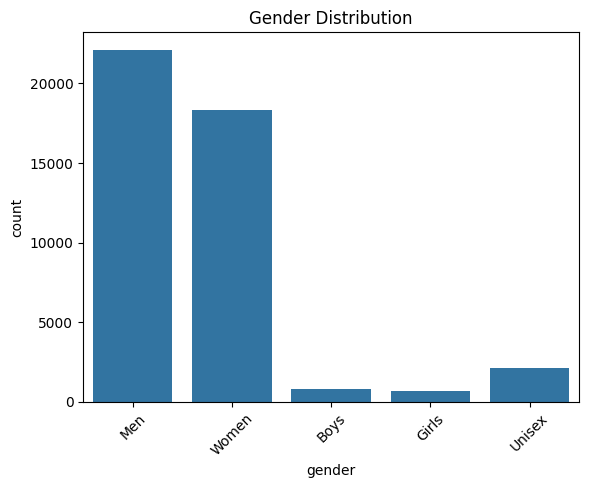

masterCategory
Apparel           21366
Accessories       11246
Footwear           9197
Personal Care      2139
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


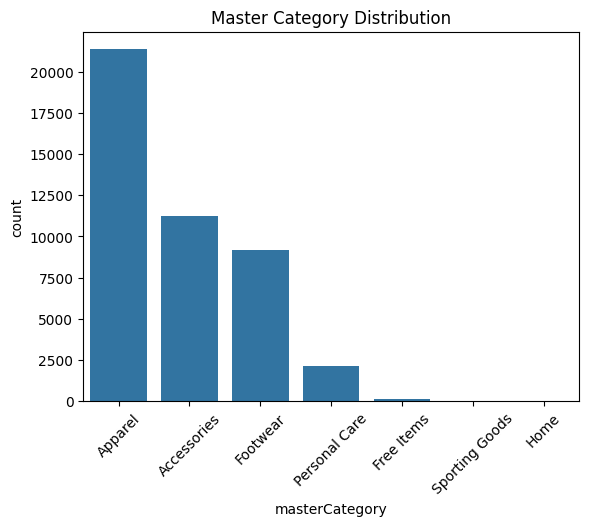

subCategory
Topwear       15387
Shoes          7323
Bags           3055
Bottomwear     2686
Watches        2542
Innerwear      1806
Jewellery      1079
Eyewear        1073
Fragrance      1001
Sandal          961
Name: count, dtype: int64


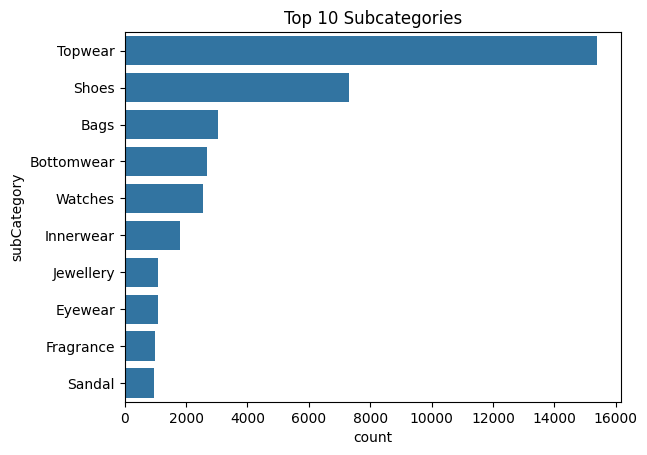

In [7]:
# EDA Step 1: Gender distribution
print(df['gender'].value_counts())
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.xticks(rotation=45)
plt.show()

# EDA Step 2: Master Category distribution
print(df['masterCategory'].value_counts())
sns.countplot(x='masterCategory', data=df)
plt.title('Master Category Distribution')
plt.xticks(rotation=45)
plt.show()

# EDA Step 3: Top Subcategories
print(df['subCategory'].value_counts().head(10))
sns.countplot(y='subCategory', data=df, order=df['subCategory'].value_counts().iloc[:10].index)
plt.title('Top 10 Subcategories')
plt.show()


In [8]:
# Step: Create combined text data per product
def combine_features(row):
    return f"{row['gender']} {row['masterCategory']} {row['subCategory']} {row['articleType']} {row['baseColour']} {row['season']} {row['usage']}"

df['combined_features'] = df.apply(combine_features, axis=1)

# Preview the new column
df[['id', 'combined_features']].head()


,id,combined_features
0,15970,Men Apparel Topwear Shirts Navy Blue Fall Casual
1,39386,Men Apparel Bottomwear Jeans Blue Summer Casual
2,59263,Women Accessories Watches Watches Silver Winte...
3,21379,Men Apparel Bottomwear Track Pants Black Fall ...
4,53759,Men Apparel Topwear Tshirts Grey Summer Casual


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# TF-IDF with limited features
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# NearestNeighbors model for finding similar items (efficient)
model = NearestNeighbors(n_neighbors=6, metric='cosine')  # Top 5 + the item itself
model.fit(tfidf_matrix)

# Map product ID to index
indices = pd.Series(df.index, index=df['id']).drop_duplicates()


In [11]:
def get_recommendations(product_id):
    if product_id not in indices:
        return "Product ID not found."

    idx = indices[product_id]
    query_vector = tfidf_matrix[idx]
    distances, indices_list = model.kneighbors(query_vector)

    recommended_indices = indices_list[0][1:]  # Exclude the product itself

    return df[['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour']].iloc[recommended_indices]


In [12]:
get_recommendations(15970)

,id,gender,masterCategory,subCategory,articleType,baseColour
32521,20141,Men,Apparel,Topwear,Shirts,Navy Blue
44001,23667,Men,Apparel,Topwear,Shirts,Navy Blue
11964,13311,Men,Apparel,Topwear,Shirts,Navy Blue
40811,16312,Men,Apparel,Topwear,Shirts,Navy Blue
25476,14663,Men,Apparel,Topwear,Shirts,Navy Blue
